## In this project we will use SciPy library to improve our portfolio by maximizing Sharpe Ratio. We will calculate the performance of the current portfolio. Also we will use minimize function from the library to find the portfolio which has maximal Sharpe Ratio.
___

# Preparations

### Import libraries

Import standard libraries we need for interaction with data - Numpy and Pandas, for visualization - Matplotlib and Seaborn, for getting financial data - yfinance and pandas_datareader.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [12, 6]
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from scipy.optimize import minimize

import datetime
import yfinance as yf
import pandas_datareader.data as web

### Create time boundaries

Creating variables with time boundaries using the datetime library.

In [7]:
end_date = datetime.datetime.now()
start_date = datetime.datetime.now() - datetime.timedelta(days=5*365)

### Init portfolio data

We have the customer portfolio consisting of 13 different stocks with actual weights in it.

In [10]:
portfolio = ['AAPL', 'ABBV', 'BAC', 'BTI', 'C', 'CMCSA', 'FDX',  'GPS', 'HPQ', 'INTC', 'PFE', 'T', 'V']
current_weights = [0.1269, 0.1082, 0.0473, 0.0762, 0.0441, 0.0627, 0.1069, 0.1006, 0.0716, 0.0401, 0.0588, 0.0689, 0.0876]
portfolio_len = len(portfolio)

# Calculate

### Load the stock data

Load the daily stock data within the 5-year time period by using yfinance.

In [14]:
stock_data = yf.download(portfolio, start_date, end_date, interval='1d')
stock_data = stock_data['Close']
stock_data = stock_data.reset_index()

[*********************100%***********************]  13 of 13 completed


### Calculate metrics

Calculate the basic metrics - historical mean return and covariance matrix.

In [17]:
# Find the quarterly return for each period
selected = list(stock_data.columns[1:])
returns = stock_data[selected].pct_change()
# Find the expected returns 
expected_returns = returns.mean()
# Find the covariance 
cov = returns.cov()

### Calculate target portfolio

Take the rate of U.S. 10 Year Treasury as the risk free rate.

In [20]:
gs10 = web.DataReader('GS10', 'fred', start_date, end_date)
riskfreerate = gs10.iloc[-1]['GS10']/100

Define a function which calculates the negative Sharpe Ratio. We use the negative Sharpe Ratio because the following optimization method has only minimize function, so the minimum of the negative Sharpe Ratio is the maximum of Sharpe Ratio we seek for different signs.

In [22]:
def getNegativeSharpeRatio(weight, returns, cov, riskfreerate = 0):
    portfolioReturn = np.dot(weight , returns)*252
    portfolioStd = np.sqrt(np.dot(weight , np.dot(cov , weight.T)))*np.sqrt(252)
    return -(portfolioReturn - riskfreerate)/portfolioStd

We aim to achieve a highly diversified portfolio by setting both minimum and maximum percentage limits, ensuring that each stock's allocation falls within this range in the final portfolio.

In [24]:
min_stock_fraction = 1/(portfolio_len*2)
max_stock_fraction = 2/portfolio_len

bounds = tuple((min_stock_fraction, max_stock_fraction) for i in range(portfolio_len))

We have the obvious condition that sum of weights has to be 1

In [26]:
cons = (
    # Sum of weights must equate to 1
    {'type' : 'eq', 'fun' : lambda w : np.sum(w) - 1})

Define a wrapper function to maximize the Sharpe Ratio.

In [28]:
def maxSR(returns, cov, bounds, cons, riskfreerate = 0):
    args = (returns, cov, riskfreerate)
    result = minimize(fun=getNegativeSharpeRatio,
                      x0=current_weights,
                      args=args,
                      bounds=bounds, 
                      constraints=cons)
    return result

Now we ready to call our implemention.

In [30]:
result = maxSR(expected_returns, cov, bounds, cons, riskfreerate=riskfreerate)
print(result)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.6052157009491571
       x: [ 1.538e-01  1.538e-01 ...  3.846e-02  5.864e-02]
     nit: 4
     jac: [-8.011e-01 -6.110e-01 ...  4.542e-01 -1.836e-02]
    nfev: 56
    njev: 4


# Results

Calculate the performance of the current portfolio.

In [33]:
current_return = np.dot(current_weights , expected_returns)*252
current_volatility = np.sqrt(np.dot(np.transpose(current_weights), np.dot(cov, current_weights)))*np.sqrt(252)
current_sharp_ratio = (current_return - riskfreerate)/current_volatility

Calculate the performance of the optimized portfolio.

In [35]:
optimized_weights = [float(round(x, 4)) for x in result['x']]

In [36]:
optimized_return = np.dot(optimized_weights , expected_returns)*252
optimized_volatility = np.sqrt(np.dot(np.transpose(optimized_weights), np.dot(cov, optimized_weights)))*np.sqrt(252)
optimized_sharp_ratio = (optimized_return - riskfreerate)/optimized_volatility

Collect portfolios to one DataFrame.

In [38]:
current_portfolio = pd.DataFrame(current_weights, index=portfolio, columns=['Current weights'])
optimized_portfolio = pd.DataFrame(optimized_weights, index=portfolio, columns=['Optimized weights'])

portfolios = pd.concat([current_portfolio, optimized_portfolio], axis=1)

portfolios

,Current weights,Optimized weights
AAPL,0.1269,0.1538
ABBV,0.1082,0.1538
BAC,0.0473,0.0385
BTI,0.0762,0.0385
C,0.0441,0.0385
CMCSA,0.0627,0.0385
FDX,0.1069,0.1538
GPS,0.1006,0.0567
HPQ,0.0716,0.1538
INTC,0.0401,0.0385


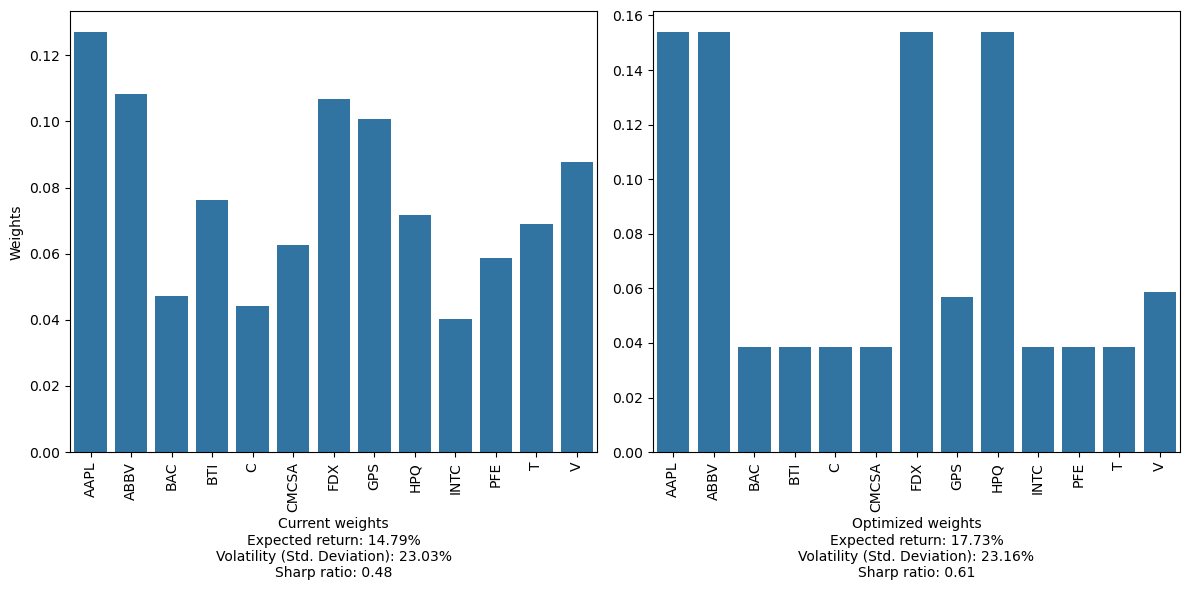

In [39]:
ax1 = plt.subplot(1,2,1)
sns.barplot(x=portfolios.index, y=portfolios['Current weights'])
plt.ylabel("Weights");
plt.xlabel(f"""Current weights
Expected return: {round(current_return*100,2)}%
Volatility (Std. Deviation): {round(current_volatility*100,2)}%
Sharp ratio: {round(current_sharp_ratio,2)}""");
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
plt.tight_layout()

ax2 = plt.subplot(1,2,2)
sns.barplot(x=portfolios.index, y=portfolios['Optimized weights'])
plt.ylabel("");
plt.xlabel(f"""Optimized weights
Expected return: {round(optimized_return*100,2)}%
Volatility (Std. Deviation): {round(optimized_volatility*100,2)}%
Sharp ratio: {round(optimized_sharp_ratio,2)}""");
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
plt.tight_layout()

plt.show()

As the results show, using portfolio optimization we can significantly improve the return and Sharpe Ratio with only minor increase volatility.